# MLP Scaling: $H$ vs $|G|$ 

Hidden neurons vs group size scaling experiments.

## Set up

In [11]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "gagf"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  /home/facosta/group-agf/gagf
Directory added to path:  /home/facosta/group-agf
Directory added to path:  /home/facosta/group-agf/gagf


## Specify experiment directory

In [12]:
# sweep_dir = "/home/facosta/group-agf/sweeps/onehot_scaling_sweep_20251215_175955"
sweep_dir = "/home/facosta/group-agf/sweep_results/onehot_scaling_sweep_20260112_022012"
print(os.path.exists(sweep_dir))

True


### Steps to Convergence

In [13]:
def load_sweep_results_grid_convergence_p_h(
    sweep_dir: str,
    k: int,
    p_values: list,
    hidden_dims: list,
    reduction_threshold: float = 0.99,
    max_p: int = None,
):
    """
    Load sweep results and compute steps to convergence for p vs hidden_dim sweep.

    Updated for experiment naming: k{k}_p{p}_h{h}
    Only loads completed experiments (checks for run_summary.yaml).

    Convergence is defined as reaching `reduction_threshold` loss reduction
    (e.g., 0.99 = 99% reduction from initial loss).

    If convergence is not reached, the grid point is set to NaN (blacked out).

    Args:
        sweep_dir: Path to the sweep directory
        k: Sequence length parameter (2, 3, or 4)
        p_values: List of p (group size) values
        hidden_dims: List of hidden dimension values
        reduction_threshold: Fraction of loss reduction to consider converged
        max_p: Maximum p value to include (filters incomplete experiments)

    Returns:
        grid: 2D array with mean steps to convergence (NaN if didn't converge)
              Shape: (len(hidden_dims), len(p_values))
        std_grid: 2D array with standard deviations across seeds
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(p_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(p_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, p in enumerate(p_values):
            # Filter by max_p if specified
            if max_p is not None and p > max_p:
                continue

            exp_name = f"k{k}_p{p}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            # Check if experiment is completed (has run_summary.yaml)
            seed_dir = exp_dir / "seed_0"
            if not seed_dir.exists() or not (seed_dir / "run_summary.yaml").exists():
                continue  # Skip incomplete experiments

            # Collect convergence steps from all seeds
            convergence_steps = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    initial_loss = loss_history[0]

                    if initial_loss > 0:
                        # Compute reduction at each step
                        reductions = 1 - loss_history / initial_loss

                        # Find first step where reduction >= threshold
                        converged_mask = reductions >= reduction_threshold
                        if np.any(converged_mask):
                            step = np.argmax(converged_mask)  # First True
                            convergence_steps.append(step)
                        # else: Never converged - don't add to list

            if convergence_steps:
                grid[i, j] = np.mean(convergence_steps)
                std_grid[i, j] = (
                    np.std(convergence_steps) if len(convergence_steps) > 1 else 0.0
                )
            # else: No seeds converged - grid[i,j] remains NaN (blacked out)

    return grid, std_grid

In [47]:
def load_sweep_results_grid_final_loss_p_h(
    sweep_dir: str,
    k: int,
    p_values: list,
    hidden_dims: list,
    max_p: int = None,
):
    """
    Load sweep results and compute final training loss for p vs hidden_dim sweep.

    Updated for experiment naming: k{k}_p{p}_h{h}
    Only loads completed experiments (checks for run_summary.yaml).

    Args:
        sweep_dir: Path to the sweep directory
        k: Sequence length parameter (2, 3, or 4)
        p_values: List of p (group size) values
        hidden_dims: List of hidden dimension values
        max_p: Maximum p value to include (filters incomplete experiments)

    Returns:
        grid: 2D array with mean final training loss (NaN if experiment incomplete)
              Shape: (len(hidden_dims), len(p_values))
        std_grid: 2D array with standard deviations across seeds
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(p_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(p_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, p in enumerate(p_values):
            # Filter by max_p if specified
            if max_p is not None and p > max_p:
                continue

            exp_name = f"k{k}_p{p}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            # Check if experiment is completed (has run_summary.yaml)
            seed_dir = exp_dir / "seed_0"
            if not seed_dir.exists() or not (seed_dir / "run_summary.yaml").exists():
                continue  # Skip incomplete experiments

            # Collect final losses from all seeds
            final_losses = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    if len(loss_history) > 0:
                        final_loss = loss_history[-1]  # Last value
                        final_losses.append(final_loss)

            if final_losses:
                grid[i, j] = np.mean(final_losses)
                std_grid[i, j] = np.std(final_losses) if len(final_losses) > 1 else 0.0
            # else: No seeds found - grid[i,j] remains NaN (blacked out)

    return grid, std_grid

In [78]:
def load_training_loss_curves_p(
    sweep_dir: str,
    k: int,
    hidden_dim: int,
    p_values: list,
):
    """
    Load training loss histories for different group sizes (p) with fixed k and hidden_dim.

    Args:
        sweep_dir: Path to the sweep directory
        k: Sequence length parameter (fixed)
        hidden_dim: Hidden dimension (fixed)
        p_values: List of p (group size) values to plot

    Returns:
        curves: Dictionary mapping p -> list of loss histories (one per seed)
                Each loss history is a numpy array
    """
    sweep_path = Path(sweep_dir)

    curves = {}

    for p in p_values:
        exp_name = f"k{k}_p{p}_h{hidden_dim}"
        exp_dir = sweep_path / exp_name

        if not exp_dir.exists():
            continue

        # Check if experiment is completed
        seed_dir = exp_dir / "seed_0"
        if not seed_dir.exists() or not (seed_dir / "run_summary.yaml").exists():
            continue  # Skip incomplete experiments

        # Collect loss histories from all seeds
        loss_histories = []
        for seed_dir in exp_dir.glob("seed_*"):
            loss_file = seed_dir / "train_loss_history.npy"
            if loss_file.exists():
                loss_history = np.load(loss_file)
                if len(loss_history) > 0:
                    loss_histories.append(loss_history)

        if loss_histories:
            curves[p] = loss_histories

    return curves

In [72]:
def load_sweep_results_grid_final_val_loss_p_h(
    sweep_dir: str,
    k: int,
    p_values: list,
    hidden_dims: list,
    max_p: int = None,
):
    """
    Load sweep results and compute final validation loss for p vs hidden_dim sweep.

    Updated for experiment naming: k{k}_p{p}_h{h}
    Only loads completed experiments (checks for run_summary.yaml).

    Args:
        sweep_dir: Path to the sweep directory
        k: Sequence length parameter (2, 3, or 4)
        p_values: List of p (group size) values
        hidden_dims: List of hidden dimension values
        max_p: Maximum p value to include (filters incomplete experiments)

    Returns:
        grid: 2D array with mean final validation loss (NaN if experiment incomplete)
              Shape: (len(hidden_dims), len(p_values))
        std_grid: 2D array with standard deviations across seeds
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(p_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(p_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, p in enumerate(p_values):
            # Filter by max_p if specified
            if max_p is not None and p > max_p:
                continue

            exp_name = f"k{k}_p{p}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            # Check if experiment is completed (has run_summary.yaml)
            seed_dir = exp_dir / "seed_0"
            if not seed_dir.exists() or not (seed_dir / "run_summary.yaml").exists():
                continue  # Skip incomplete experiments

            # Collect final validation losses from all seeds
            final_losses = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "val_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    if len(loss_history) > 0:
                        final_loss = loss_history[-1]  # Last value
                        final_losses.append(final_loss)

            if final_losses:
                grid[i, j] = np.mean(final_losses)
                std_grid[i, j] = np.std(final_losses) if len(final_losses) > 1 else 0.0
            # else: No seeds found - grid[i,j] remains NaN (blacked out)

    return grid, std_grid

In [69]:
# Define parameter values from the sweep config
# Filter to p <= 55 for completed experiments
p_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
hidden_dims = [80, 160, 240, 320, 400, 480, 560, 640, 720, 800, 880, 960, 1040, 1120]
k_values = [2, 3]  # , 4]  # Different k values to plot separately

### Plot steps to convergence grid

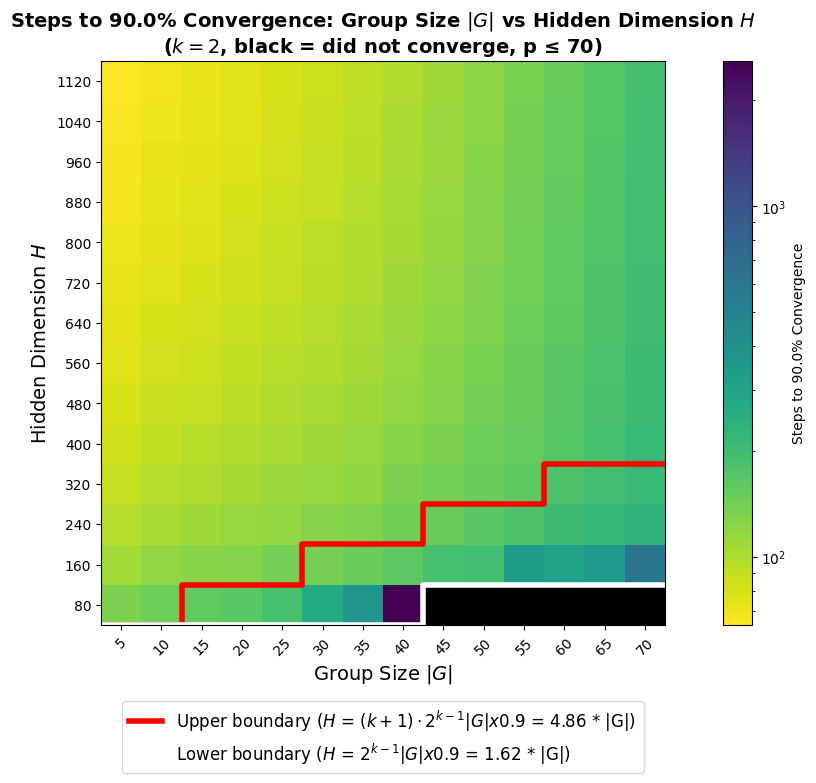

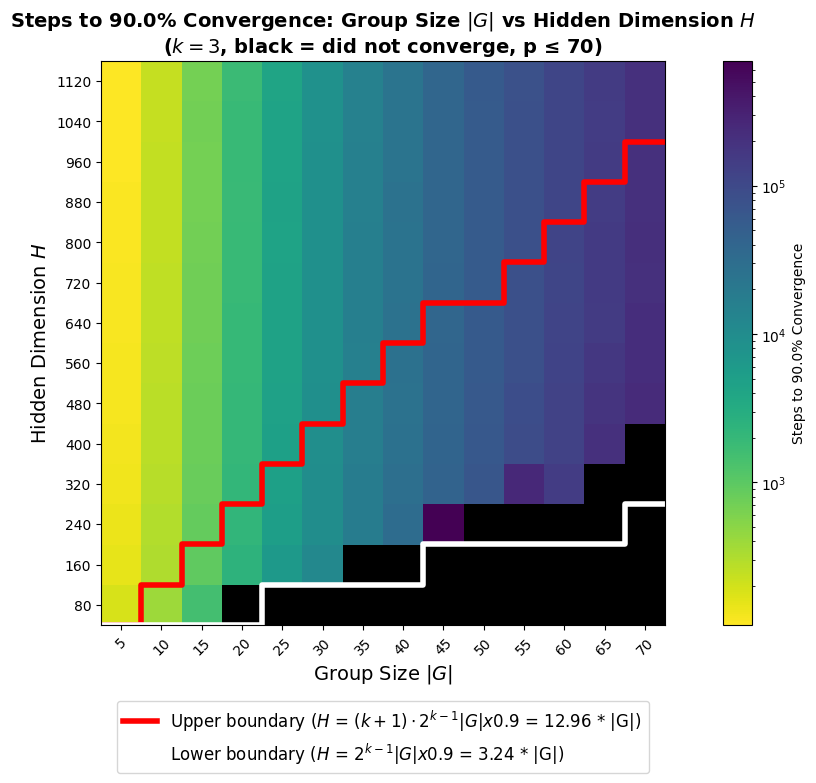

In [70]:
# Load convergence data for each k value separately
reduction_threshold = 0.90
max_p = 70  # Only visualize completed experiments (p <= 55)

from matplotlib.colors import LogNorm

# Create separate plots for each k value
for k in k_values:
    conv_grid, conv_std = load_sweep_results_grid_convergence_p_h(
        sweep_dir,
        k,
        p_values,
        hidden_dims,
        reduction_threshold=reduction_threshold,
        max_p=max_p,
    )

    # Filter p values - only show p <= max_p
    p_values_filtered = [p for p in p_values if p <= max_p]

    # Plot convergence heatmap: p (group size) vs hidden_dim
    plt.figure(figsize=(12, 8))
    cmap = plt.cm.viridis_r.copy()
    cmap.set_bad(color="black")
    # Set extent to align cells with tick positions
    # extent: [left, right, bottom, top] in data coordinates
    plt.imshow(
        conv_grid[:, : len(p_values_filtered)],
        aspect="equal",
        cmap=cmap,
        norm=LogNorm(),
    )

    plt.xlabel("Group Size $|G|$", fontsize=14)
    plt.ylabel("Hidden Dimension $H$", fontsize=14)
    plt.xticks(
        range(len(p_values_filtered)), p_values_filtered, rotation=45, ha="center"
    )

    # Set y-axis ticks (hidden dimensions)
    plt.yticks(range(len(hidden_dims)), hidden_dims)
    plt.gca().invert_yaxis()

    # Theory boundaries
    x_step = np.arange(len(p_values_filtered) + 1) - 0.5

    # Upper boundary: H = (k+1)*2^{k-1} * |G|
    upper_boundary_coeff = (k + 1) * (2 ** (k - 1)) * reduction_threshold
    y_step_upper = [
        min(
            len(hidden_dims) - 1,
            (
                # Find the first H that satisfies H >= upper_boundary_coeff * p
                np.argmax(np.array(hidden_dims) >= upper_boundary_coeff * p)
                if upper_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_upper.append(y_step_upper[-1])  # Extend for step plot
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_upper = [y - 0.5 for y in y_step_upper]

    # Lower boundary: H = 2^{k-1} * |G|
    lower_boundary_coeff = 2 ** (k - 1) * reduction_threshold
    y_step_lower = [
        min(
            len(hidden_dims) - 1,
            (
                # Find the first H that satisfies H >= lower_boundary_coeff * p
                np.argmax(np.array(hidden_dims) >= lower_boundary_coeff * p)
                if lower_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_lower.append(y_step_lower[-1])  # Extend for step plot
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_lower = [y - 0.5 for y in y_step_lower]

    plt.step(
        x_step,
        y_step_upper,
        where="post",
        color="red",
        linewidth=4,
        linestyle="-",
        label=f"Upper boundary ($H$ = $(k+1) \\cdot 2^{{k-1}} |G| x {reduction_threshold}$ = {upper_boundary_coeff * reduction_threshold} * |G|) ",
    )

    plt.step(
        x_step,
        y_step_lower,
        where="post",
        color="white",
        linewidth=4,
        linestyle="-",
        label=f"Lower boundary ($H$ = $2^{{k-1}} |G| x {reduction_threshold}$ = {lower_boundary_coeff * reduction_threshold} * |G|) ",
    )

    # Place legend outside the plot area
    plt.legend(
        loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize=12, frameon=True
    )

    plt.colorbar(label=f"Steps to {reduction_threshold*100}% Convergence")
    plt.title(
        f"Steps to {reduction_threshold*100}% Convergence: Group Size $|G|$ vs Hidden Dimension $H$\n($k={k}$, black = did not converge, p ≤ {max_p})",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()

### Final Training Loss
    

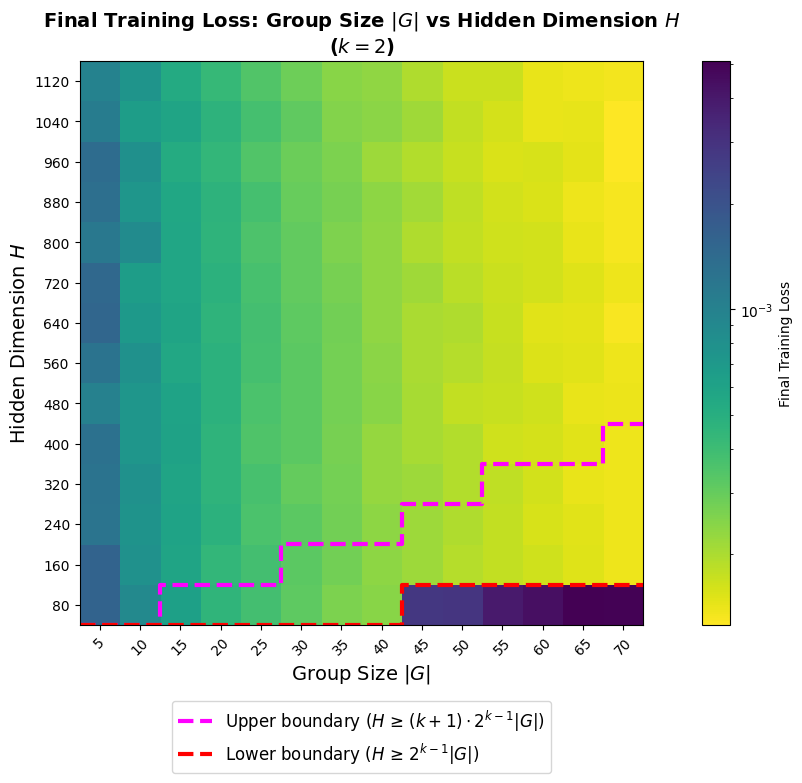

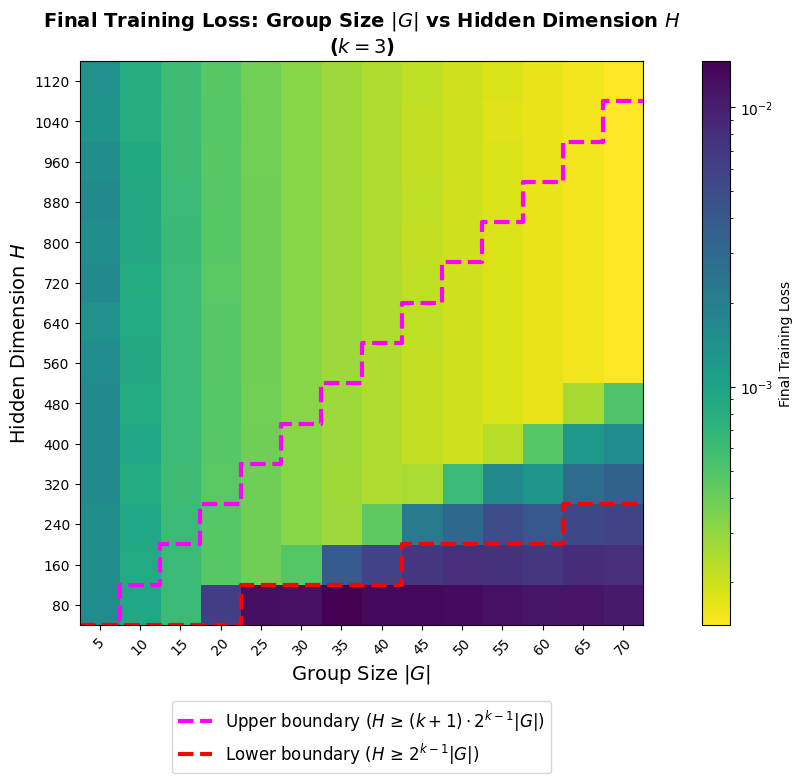

In [74]:
# Load final training loss data for each k value separately
max_p = 70  # Only visualize completed experiments (p <= 55)

from matplotlib.colors import LogNorm

# Create separate plots for each k value
for k in k_values:
    loss_grid, loss_std = load_sweep_results_grid_final_loss_p_h(
        sweep_dir,
        k,
        p_values,
        hidden_dims,
        max_p=max_p,
    )

    # Filter p values - only show p <= max_p
    p_values_filtered = [p for p in p_values if p <= max_p]

    # Plot final loss heatmap: p (group size) vs hidden_dim
    plt.figure(figsize=(12, 8))
    cmap = plt.cm.viridis_r.copy()
    cmap.set_bad(color="black")
    # Set extent to align cells with tick positions
    # extent: [left, right, bottom, top] in data coordinates
    plt.imshow(
        loss_grid[:, : len(p_values_filtered)],
        aspect="equal",
        cmap=cmap,
        norm=LogNorm(),
    )

    plt.xlabel("Group Size $|G|$", fontsize=14)
    plt.ylabel("Hidden Dimension $H$", fontsize=14)
    plt.xticks(
        range(len(p_values_filtered)), p_values_filtered, rotation=45, ha="center"
    )

    # Set y-axis ticks (hidden dimensions)
    plt.yticks(range(len(hidden_dims)), hidden_dims)
    plt.gca().invert_yaxis()

    # Theory boundaries
    x_step = np.arange(len(p_values_filtered) + 1) - 0.5

    # Upper boundary: H = (k+1)*2^{k-1} * |G|
    upper_boundary_coeff = (k + 1) * (2 ** (k - 1))
    y_step_upper = [
        min(
            len(hidden_dims) - 1,
            (
                # Find the first H that satisfies H >= upper_boundary_coeff * p
                np.argmax(np.array(hidden_dims) >= upper_boundary_coeff * p)
                if upper_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_upper.append(y_step_upper[-1])  # Extend for step plot
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_upper = [y - 0.5 for y in y_step_upper]

    # Lower boundary: H = 2^{k-1} * |G|
    lower_boundary_coeff = 2 ** (k - 1)
    y_step_lower = [
        min(
            len(hidden_dims) - 1,
            (
                # Find the first H that satisfies H >= lower_boundary_coeff * p
                np.argmax(np.array(hidden_dims) >= lower_boundary_coeff * p)
                if lower_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_lower.append(y_step_lower[-1])  # Extend for step plot
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_lower = [y - 0.5 for y in y_step_lower]

    plt.step(
        x_step,
        y_step_upper,
        where="post",
        color="magenta",
        linewidth=3,
        linestyle="--",
        label=f"Upper boundary ($H$ ≥ $(k+1) \\cdot 2^{{k-1}} |G|$)",
    )

    plt.step(
        x_step,
        y_step_lower,
        where="post",
        color="red",
        linewidth=3,
        linestyle="--",
        label=f"Lower boundary ($H$ ≥ $2^{{k-1}} |G|$)",
    )

    # Place legend outside the plot area
    plt.legend(
        loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize=12, frameon=True
    )

    plt.colorbar(label="Final Training Loss")
    plt.title(
        f"Final Training Loss: Group Size $|G|$ vs Hidden Dimension $H$\n($k={k}$)",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()

### Training Loss Curves by Group Size


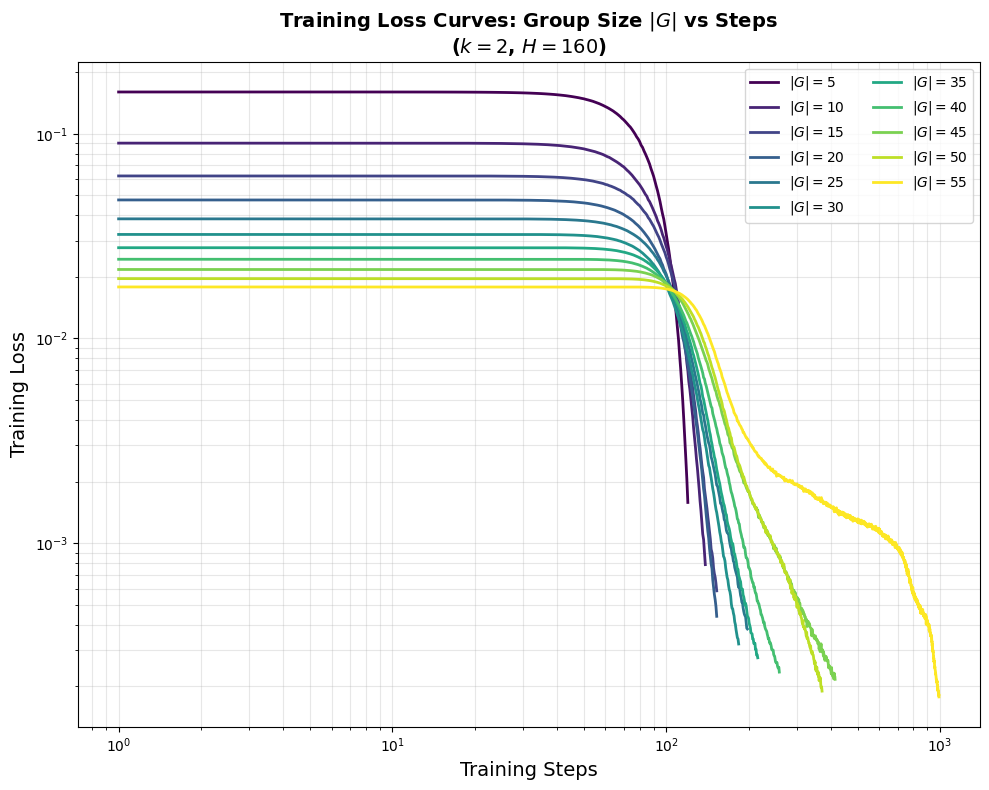

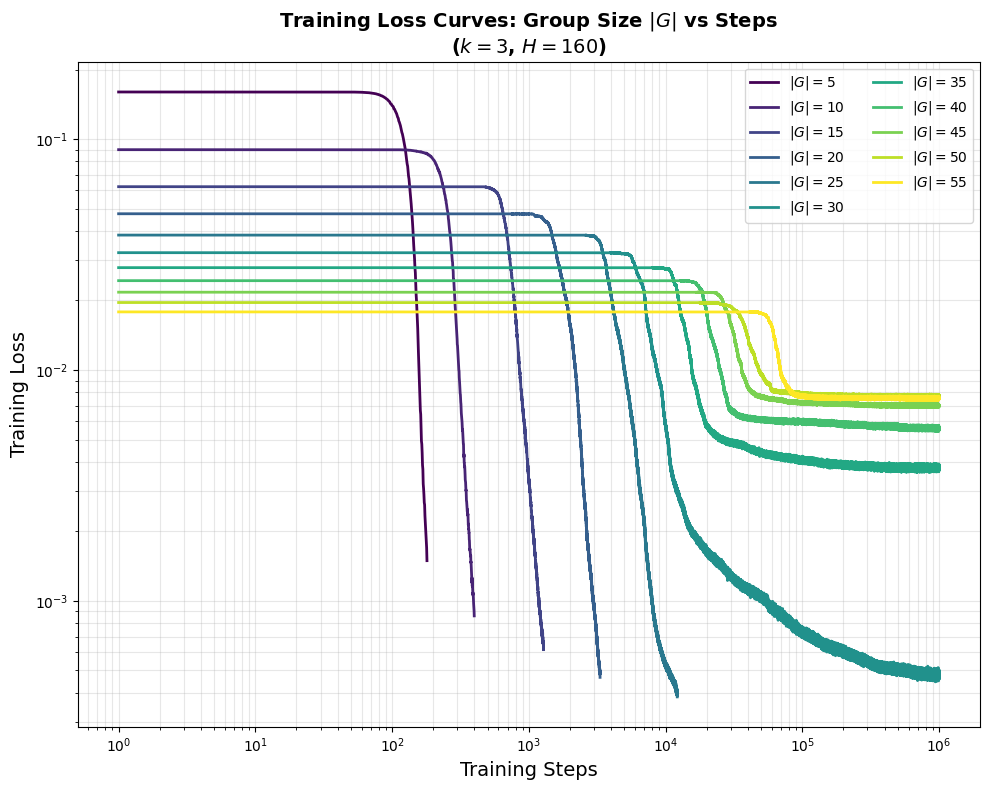

In [82]:
# Plot training loss curves for different group sizes
# Specify the hidden dimension to use
hidden_dim = 160  # Change this to plot different hidden dimensions

# Use all available p values (or filter as needed)
p_values_to_plot = [p for p in p_values if p <= 55]  # Adjust max_p as needed

# Create separate plots for each k value
for k in k_values:
    # Load training loss curves for different p values
    curves = load_training_loss_curves_p(
        sweep_dir,
        k,
        hidden_dim,
        p_values_to_plot,
    )

    if not curves:
        print(f"No data found for k={k}, H={hidden_dim}")
        continue

    # Create plot
    plt.figure(figsize=(10, 8))

    # Plot each group size as a separate curve
    # Use a colormap to distinguish different p values
    colors = plt.cm.viridis(np.linspace(0, 1, len(curves)))

    for i, (p, loss_histories) in enumerate(sorted(curves.items())):
        # Plot mean curve with shaded error bars
        # Find the maximum length to align all curves
        max_len = max(len(hist) for hist in loss_histories)

        # Pad shorter histories with NaN or last value
        aligned_histories = []
        for hist in loss_histories:
            if len(hist) < max_len:
                padded = np.full(max_len, np.nan)
                padded[: len(hist)] = hist
                aligned_histories.append(padded)
            else:
                aligned_histories.append(hist)

        aligned_histories = np.array(aligned_histories)

        # Compute mean and std across seeds
        mean_loss = np.nanmean(aligned_histories, axis=0)
        std_loss = np.nanstd(aligned_histories, axis=0)

        # Create step array (1-indexed for log scale)
        steps = np.arange(1, len(mean_loss) + 1)

        # Plot mean curve
        plt.loglog(
            steps,
            mean_loss,
            color=colors[i],
            linewidth=2,
            label=f"$|G|={p}$",
        )

        # Plot shaded error region (optional, can be commented out if too cluttered)
        # plt.fill_between(
        #     steps,
        #     mean_loss - std_loss,
        #     mean_loss + std_loss,
        #     color=colors[i],
        #     alpha=0.2,
        # )

    plt.xlabel("Training Steps", fontsize=14)
    plt.ylabel("Training Loss", fontsize=14)
    plt.title(
        f"Training Loss Curves: Group Size $|G|$ vs Steps\n($k={k}$, $H={hidden_dim}$)",
        fontsize=14,
        fontweight="bold",
    )
    plt.legend(loc="best", fontsize=10, ncol=2)
    plt.grid(True, alpha=0.3, which="both")
    plt.tight_layout()
    plt.show()

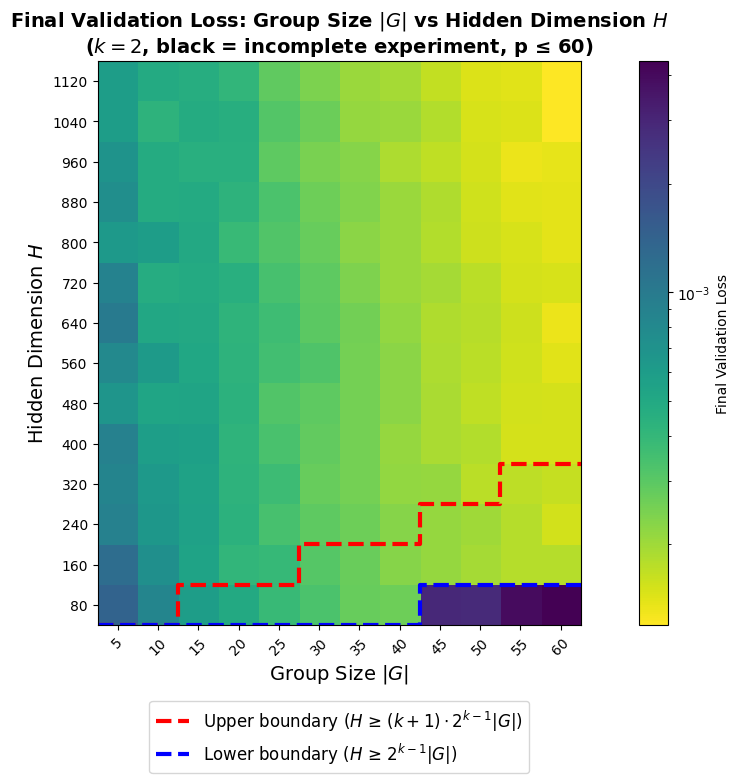

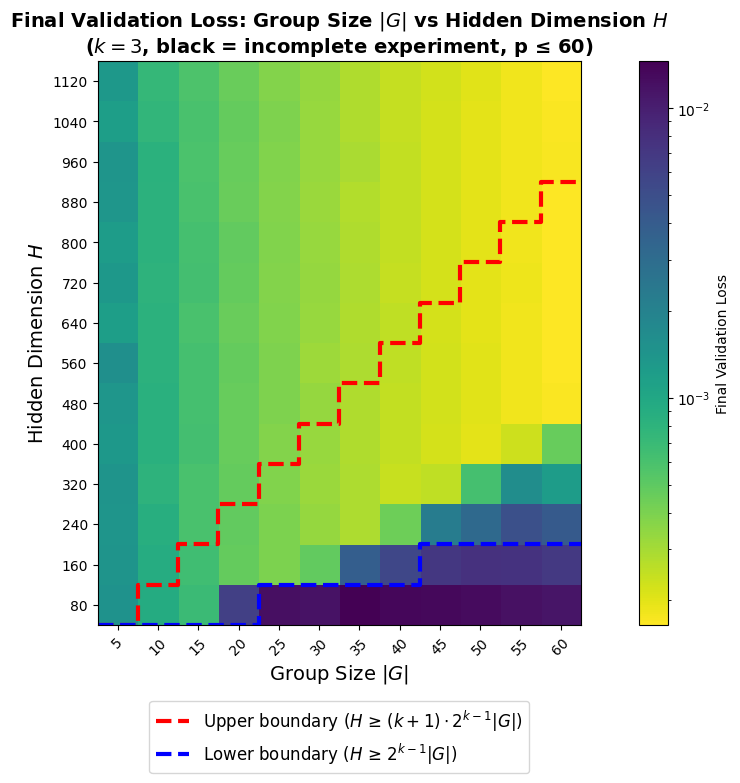

In [73]:
# Load final validation loss data for each k value separately
max_p = 60  # Only visualize completed experiments (p <= 55)

from matplotlib.colors import LogNorm

# Create separate plots for each k value
for k in k_values:
    loss_grid, loss_std = load_sweep_results_grid_final_val_loss_p_h(
        sweep_dir,
        k,
        p_values,
        hidden_dims,
        max_p=max_p,
    )

    # Filter p values - only show p <= max_p
    p_values_filtered = [p for p in p_values if p <= max_p]

    # Plot final validation loss heatmap: p (group size) vs hidden_dim
    plt.figure(figsize=(12, 8))
    cmap = plt.cm.viridis_r.copy()
    cmap.set_bad(color="black")
    # Set extent to align cells with tick positions
    # extent: [left, right, bottom, top] in data coordinates
    plt.imshow(
        loss_grid[:, : len(p_values_filtered)],
        aspect="equal",
        cmap=cmap,
        norm=LogNorm(),
    )

    plt.xlabel("Group Size $|G|$", fontsize=14)
    plt.ylabel("Hidden Dimension $H$", fontsize=14)
    plt.xticks(
        range(len(p_values_filtered)), p_values_filtered, rotation=45, ha="center"
    )

    # Set y-axis ticks (hidden dimensions)
    plt.yticks(range(len(hidden_dims)), hidden_dims)
    plt.gca().invert_yaxis()

    # Theory boundaries
    x_step = np.arange(len(p_values_filtered) + 1) - 0.5

    # Upper boundary: H = (k+1)*2^{k-1} * |G|
    upper_boundary_coeff = (k + 1) * (2 ** (k - 1))
    y_step_upper = [
        min(
            len(hidden_dims) - 1,
            (
                # Find the first H that satisfies H >= upper_boundary_coeff * p
                np.argmax(np.array(hidden_dims) >= upper_boundary_coeff * p)
                if upper_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_upper.append(y_step_upper[-1])  # Extend for step plot
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_upper = [y - 0.5 for y in y_step_upper]

    # Lower boundary: H = 2^{k-1} * |G|
    lower_boundary_coeff = 2 ** (k - 1)
    y_step_lower = [
        min(
            len(hidden_dims) - 1,
            (
                # Find the first H that satisfies H >= lower_boundary_coeff * p
                np.argmax(np.array(hidden_dims) >= lower_boundary_coeff * p)
                if lower_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_lower.append(y_step_lower[-1])  # Extend for step plot
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_lower = [y - 0.5 for y in y_step_lower]

    plt.step(
        x_step,
        y_step_upper,
        where="post",
        color="red",
        linewidth=3,
        linestyle="--",
        label=f"Upper boundary ($H$ ≥ $(k+1) \\cdot 2^{{k-1}} |G|$)",
    )

    plt.step(
        x_step,
        y_step_lower,
        where="post",
        color="blue",
        linewidth=3,
        linestyle="--",
        label=f"Lower boundary ($H$ ≥ $2^{{k-1}} |G|$)",
    )

    # Place legend outside the plot area
    plt.legend(
        loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize=12, frameon=True
    )

    plt.colorbar(label="Final Validation Loss")
    plt.title(
        f"Final Validation Loss: Group Size $|G|$ vs Hidden Dimension $H$\n($k={k}$, black = incomplete experiment, p ≤ {max_p})",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()

### Training Instability

In [75]:
def load_sweep_results_grid_spikiness_p_h(
    sweep_dir: str, k: int, p_values: list, hidden_dims: list, max_p: int = None
):
    """
    Compute fraction of training steps where loss increased (instability) for p vs h sweeps.

    Updated for experiment naming: k{k}_p{p}_h{h}
    Only loads completed experiments (checks for run_summary.yaml).

    Args:
        sweep_dir: Path to the sweep directory
        k: Sequence length parameter (2, 3, or 4)
        p_values: List of p (group size) values
        hidden_dims: List of hidden dimension values
        max_p: Maximum p value to include (filters incomplete experiments)

    Returns:
        grid: 2D array with mean frac_upward across seeds
              Shape: (len(hidden_dims), len(p_values))
        std_grid: 2D array with standard deviations
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(p_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(p_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, p in enumerate(p_values):
            # Filter by max_p if specified
            if max_p is not None and p > max_p:
                continue

            exp_name = f"k{k}_p{p}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            # Check if experiment is completed
            seed_dir = exp_dir / "seed_0"
            if not seed_dir.exists() or not (seed_dir / "run_summary.yaml").exists():
                continue  # Skip incomplete experiments

            frac_upwards = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    log_loss = np.log10(loss_history + 1e-10)
                    log_changes = np.diff(log_loss)

                    # Fraction of steps where loss went UP
                    frac_upward = np.sum(log_changes > 0) / len(log_changes)
                    frac_upwards.append(frac_upward)

            if frac_upwards:
                grid[i, j] = np.mean(frac_upwards)
                std_grid[i, j] = np.std(frac_upwards) if len(frac_upwards) > 1 else 0.0

    return grid, std_grid

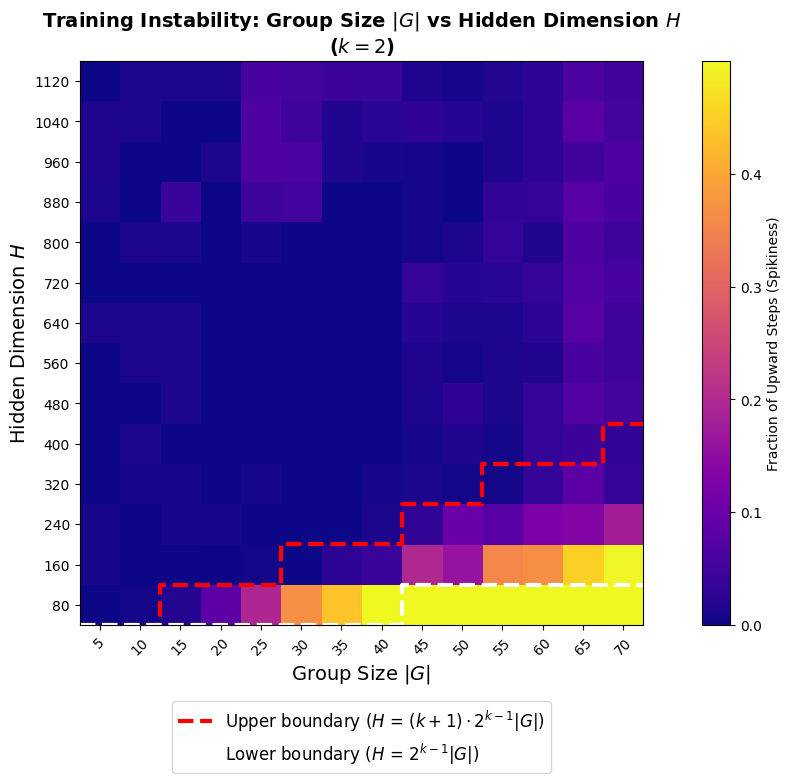

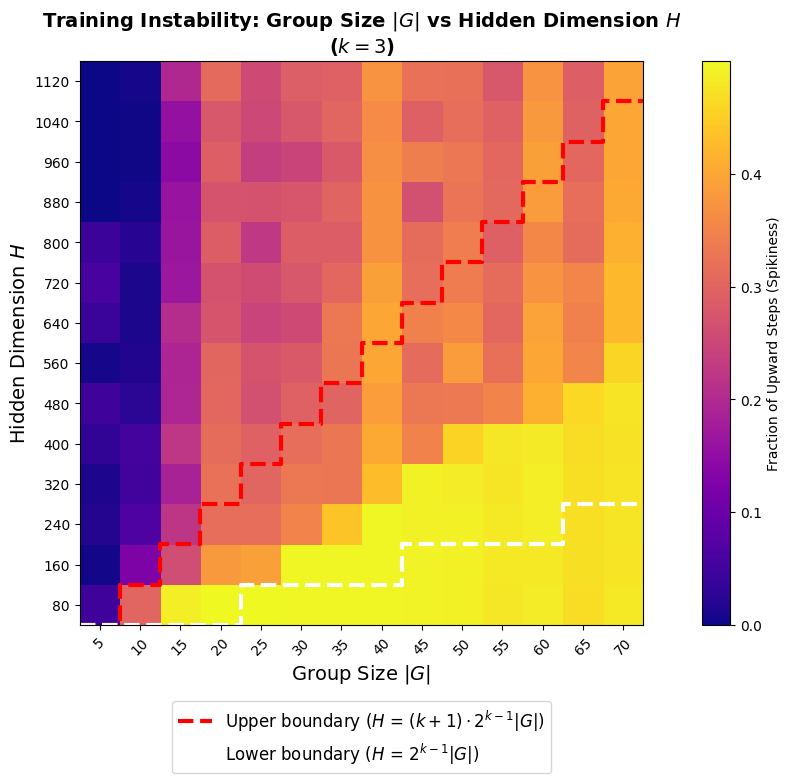

In [77]:
# Load spikiness data for each k value separately
max_p = 70  # Only visualize completed experiments

# Create separate plots for each k value
for k in k_values:
    spike_grid_p, spike_std_p = load_sweep_results_grid_spikiness_p_h(
        sweep_dir, k, p_values, hidden_dims, max_p=max_p
    )

    p_values_filtered = [p for p in p_values if p <= max_p]

    # Plot
    plt.figure(figsize=(12, 8))
    # Set extent to align cells with tick positions
    plt.imshow(
        spike_grid_p[:, : len(p_values_filtered)],
        aspect="equal",
        cmap="plasma",
        extent=[-0.5, len(p_values_filtered) - 0.5, len(hidden_dims) - 0.5, -0.5],
    )
    plt.xlabel("Group Size $|G|$", fontsize=14)
    plt.ylabel("Hidden Dimension $H$", fontsize=14)
    plt.xticks(
        range(len(p_values_filtered)), p_values_filtered, rotation=45, ha="center"
    )
    plt.yticks(range(len(hidden_dims)), hidden_dims)
    plt.gca().invert_yaxis()

    # Theory boundaries
    x_step = np.arange(len(p_values_filtered) + 1) - 0.5

    # Upper boundary: H = (k+1)*2^{k-1} * |G|
    upper_boundary_coeff = (k + 1) * (2 ** (k - 1))
    y_step_upper = [
        min(
            len(hidden_dims) - 1,
            (
                np.argmax(np.array(hidden_dims) >= upper_boundary_coeff * p)
                if upper_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_upper.append(y_step_upper[-1])
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_upper = [y - 0.5 for y in y_step_upper]

    # Lower boundary: H = 2^{k-1} * |G|
    lower_boundary_coeff = 2 ** (k - 1)
    y_step_lower = [
        min(
            len(hidden_dims) - 1,
            (
                np.argmax(np.array(hidden_dims) >= lower_boundary_coeff * p)
                if lower_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_lower.append(y_step_lower[-1])
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_lower = [y - 0.5 for y in y_step_lower]

    plt.step(
        x_step,
        y_step_upper,
        where="post",
        color="red",
        linewidth=3,
        linestyle="--",
        label=f"Upper boundary ($H$ = $(k+1) \\cdot 2^{{k-1}} |G|$)",
    )

    plt.step(
        x_step,
        y_step_lower,
        where="post",
        color="white",
        linewidth=3,
        linestyle="--",
        label=f"Lower boundary ($H$ = $2^{{k-1}} |G|$)",
    )

    plt.legend(
        loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize=12, frameon=True
    )

    plt.colorbar(label="Fraction of Upward Steps (Spikiness)")
    plt.title(
        f"Training Instability: Group Size $|G|$ vs Hidden Dimension $H$\n($k={k}$)",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()

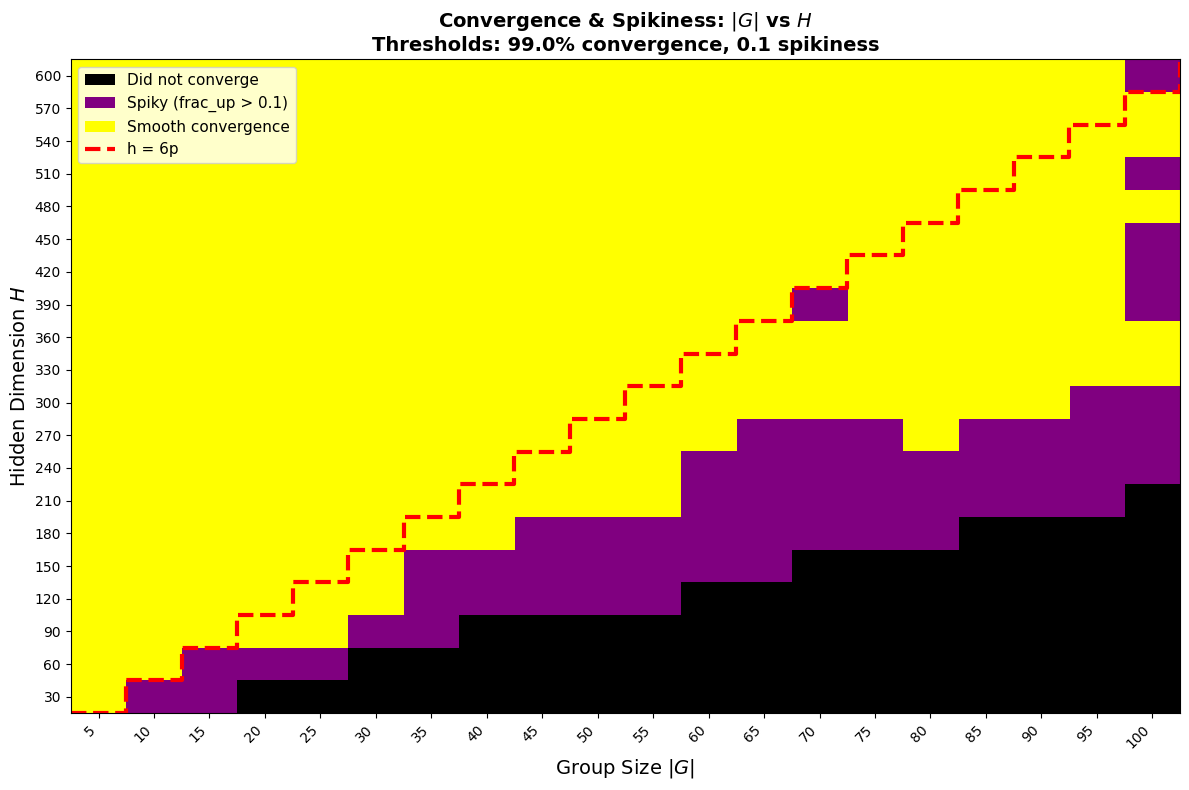

In [ ]:
# Load both metrics for each k value separately
reduction_threshold = 0.99
spikiness_threshold = 0.1
max_p = 55  # Only visualize completed experiments

# Create separate plots for each k value
for k in k_values:
    conv_grid_p, conv_std_p = load_sweep_results_grid_convergence_p_h(
        sweep_dir, k, p_values, hidden_dims, 
        reduction_threshold=reduction_threshold,
        max_p=max_p
    )
    spike_grid_p, spike_std_p = load_sweep_results_grid_spikiness_p_h(
        sweep_dir, k, p_values, hidden_dims, max_p=max_p
    )
    
    p_values_filtered = [p for p in p_values if p <= max_p]

    # Create categorical grid: 0=black (no conv), 1=purple (spiky), 2=yellow (smooth)
    category_grid = np.full((len(hidden_dims), len(p_values_filtered)), 0.0)  # Start with 0 (black)

    for i in range(len(hidden_dims)):
        for j in range(len(p_values_filtered)):
            converged = not np.isnan(conv_grid_p[i, j])

            if converged:
                spiky = spike_grid_p[i, j] > spikiness_threshold
                if spiky:
                    category_grid[i, j] = 1.0  # Purple (spiky)
                else:
                    category_grid[i, j] = 2.0  # Yellow (smooth)
            # else stays 0.0 (black, did not converge)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Custom colormap: black -> purple -> yellow
    from matplotlib.colors import ListedColormap

    colors = ["black", "purple", "yellow"]
    cmap = ListedColormap(colors)

    # Set extent to align cells with tick positions
    im = ax.imshow(
        category_grid, 
        aspect="auto", 
        cmap=cmap, 
        vmin=0, 
        vmax=2,
        extent=[-0.5, len(p_values_filtered) - 0.5, len(hidden_dims) - 0.5, -0.5]
    )

    ax.set_xlabel("Group Size $|G|$", fontsize=14)
    ax.set_ylabel("Hidden Dimension $H$", fontsize=14)

    # Set x-axis ticks (p values)
    ax.set_xticks(range(len(p_values_filtered)))
    ax.set_xticklabels(p_values_filtered, rotation=45, ha="center")

    # Set y-axis ticks (hidden dimensions)
    ax.set_yticks(range(len(hidden_dims)))
    ax.set_yticklabels(hidden_dims)
    ax.invert_yaxis()

    # Theory boundaries
    x_step = np.arange(len(p_values_filtered) + 1) - 0.5
    
    # Upper boundary: H = (k+1)*2^{k-1} * |G|
    upper_boundary_coeff = (k + 1) * (2 ** (k - 1))
    y_step_upper = [
        min(
            len(hidden_dims) - 1,
            (
                np.argmax(np.array(hidden_dims) >= upper_boundary_coeff * p)
                if upper_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_upper.append(y_step_upper[-1])
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_upper = [y - 0.5 for y in y_step_upper]

    # Lower boundary: H = 2^{k-1} * |G|
    lower_boundary_coeff = 2 ** (k - 1)
    y_step_lower = [
        min(
            len(hidden_dims) - 1,
            (
                np.argmax(np.array(hidden_dims) >= lower_boundary_coeff * p)
                if lower_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_lower.append(y_step_lower[-1])
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_lower = [y - 0.5 for y in y_step_lower]

    ax.step(
        x_step,
        y_step_upper,
        where="post",
        color="red",
        linewidth=3,
        linestyle="--",
        label=f"Upper boundary ($H$ ≥ $(k+1) \\cdot 2^{{k-1}} |G|$)",
    )
    
    ax.step(
        x_step,
        y_step_lower,
        where="post",
        color="blue",
        linewidth=3,
        linestyle="--",
        label=f"Lower boundary ($H$ ≥ $2^{{k-1}} |G|$)",
    )

    # Create custom legend
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="black", label="Did not converge"),
        Patch(facecolor="purple", label=f"Spiky (frac_up > {spikiness_threshold})"),
        Patch(facecolor="yellow", label="Smooth convergence"),
        plt.Line2D([0], [0], color="r", linewidth=3, linestyle="--", label=f"Upper boundary ($H$ ≥ $(k+1) \\cdot 2^{{k-1}} |G|$)"),
        plt.Line2D([0], [0], color="b", linewidth=3, linestyle="--", label=f"Lower boundary ($H$ ≥ $2^{{k-1}} |G|$)"),
    ]

    ax.legend(handles=legend_elements, loc="upper left", fontsize=11, frameon=True)

    ax.set_title(
        f"Convergence & Spikiness: $|G|$ vs $H$ ($k={k}$)\nThresholds: {reduction_threshold*100}% convergence, {spikiness_threshold} spikiness (p ≤ {max_p})",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()

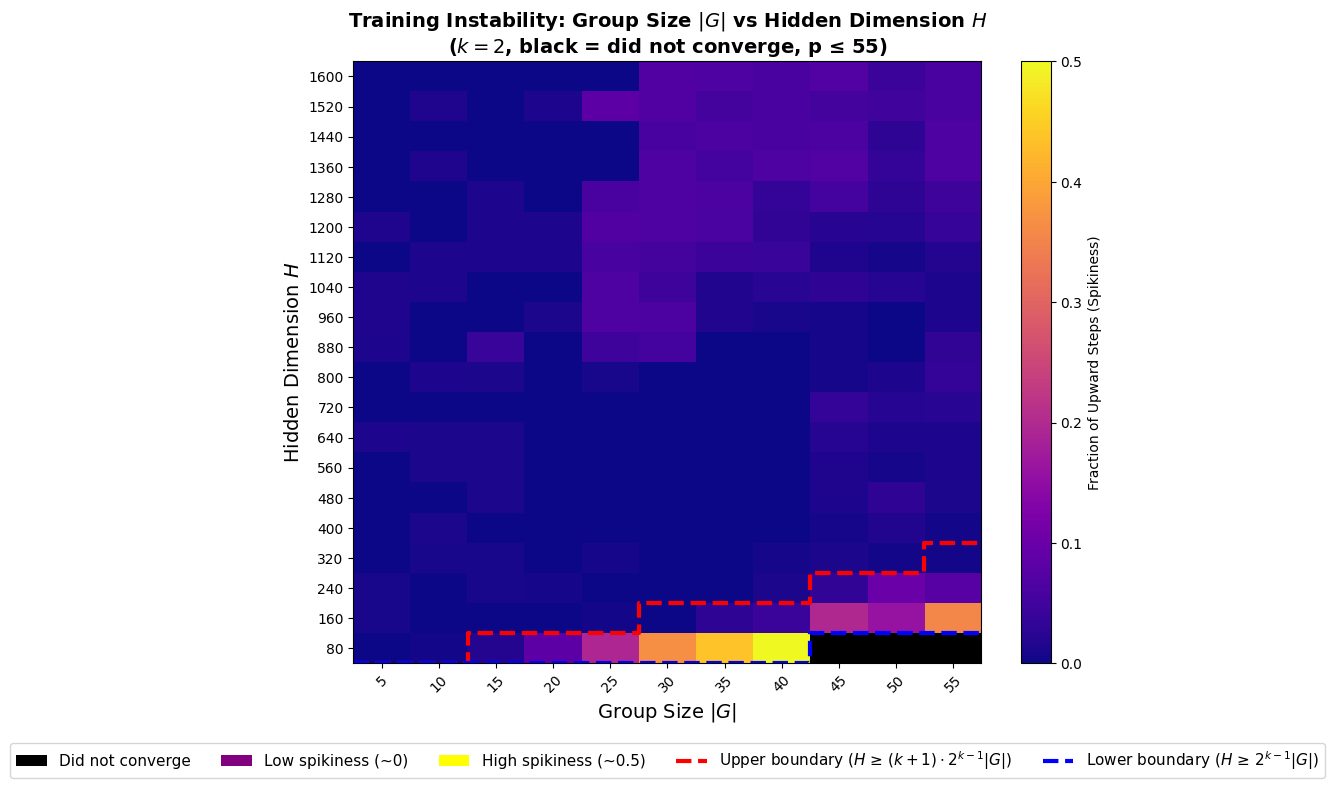

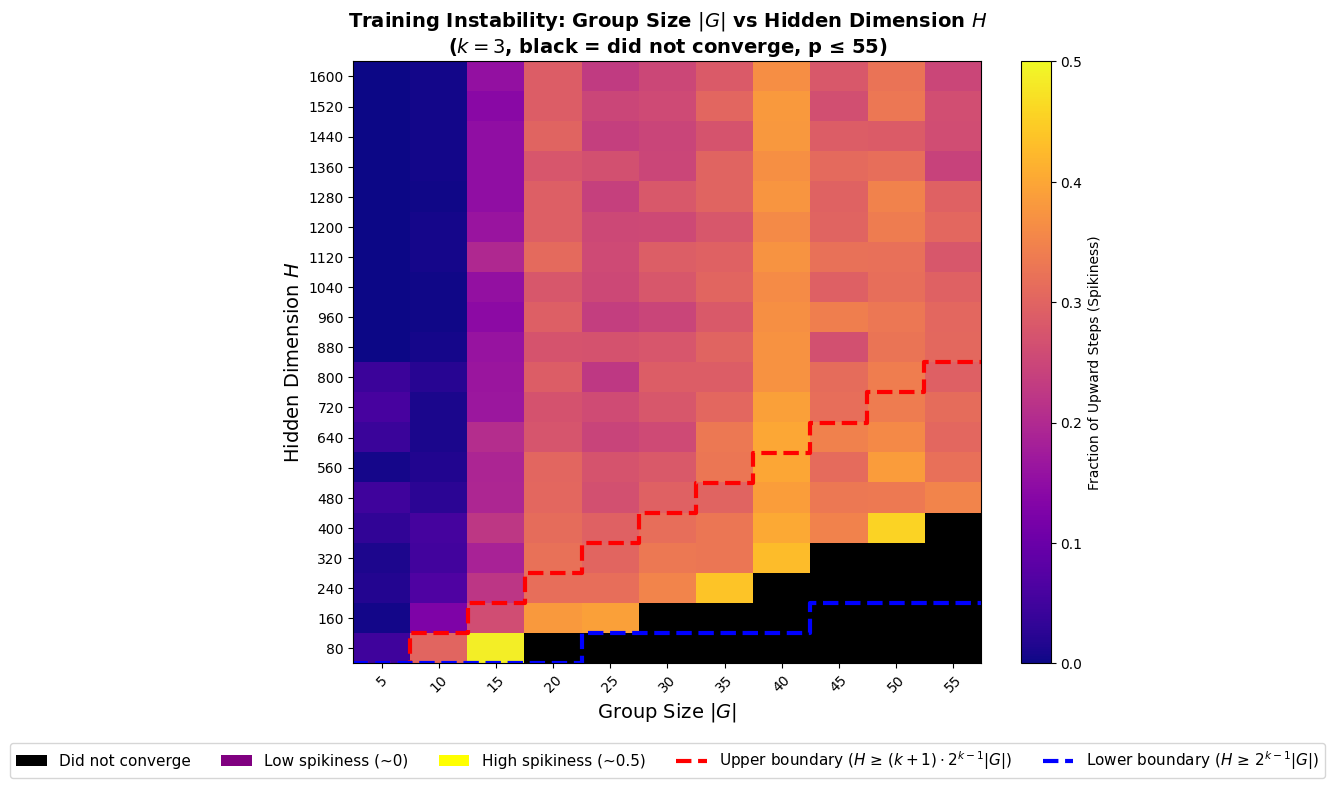

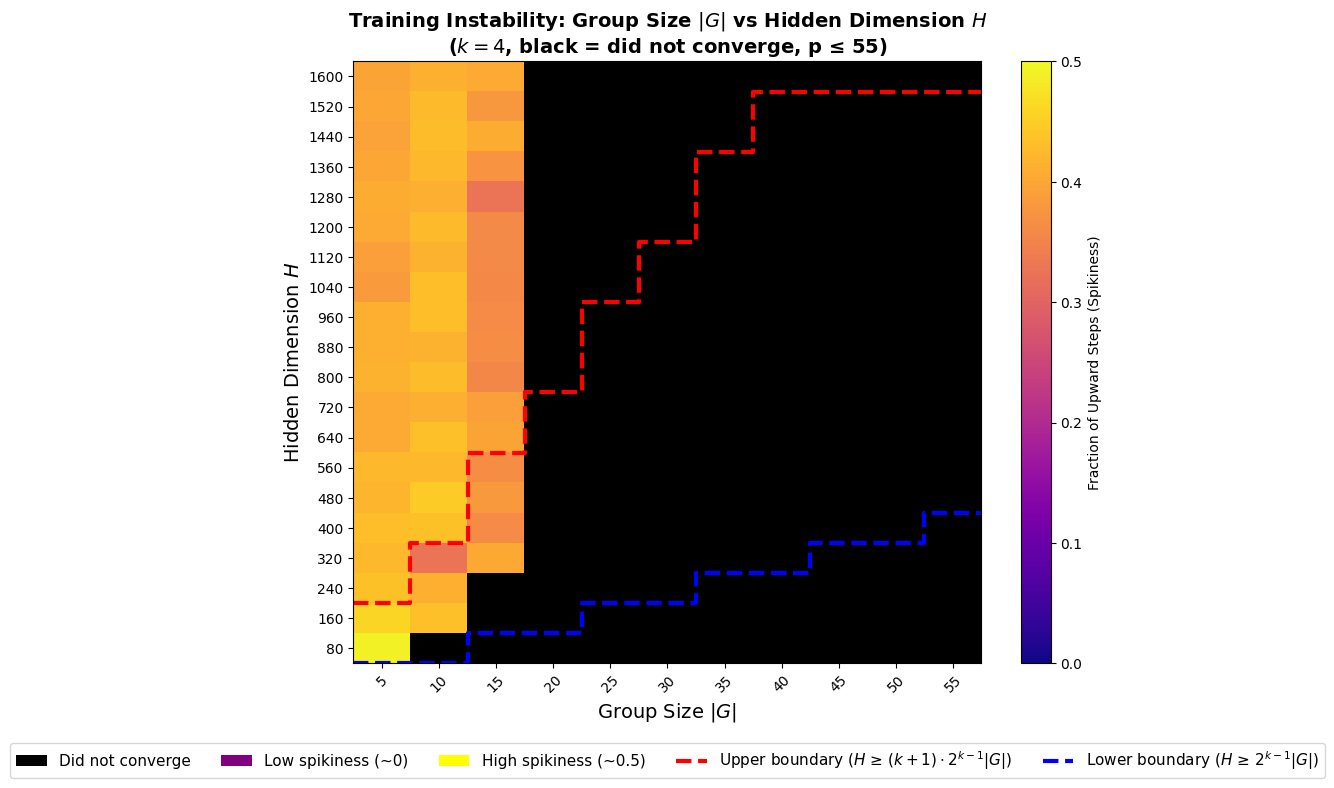

In [ ]:
# Load both convergence and spikiness data for each k value separately
reduction_threshold = 0.99
max_p = 55  # Only visualize completed experiments

# Create separate plots for each k value
for k in k_values:
    conv_grid_p, conv_std_p = load_sweep_results_grid_convergence_p_h(
        sweep_dir,
        k,
        p_values,
        hidden_dims,
        reduction_threshold=reduction_threshold,
        max_p=max_p,
    )
    spike_grid_p, spike_std_p = load_sweep_results_grid_spikiness_p_h(
        sweep_dir, k, p_values, hidden_dims, max_p=max_p
    )

    p_values_filtered = [p for p in p_values if p <= max_p]

    # Mask spikiness grid: only show spikiness for converged runs
    spike_grid_masked = spike_grid_p.copy()
    for i in range(len(hidden_dims)):
        for j in range(len(p_values_filtered)):
            if np.isnan(conv_grid_p[i, j]):
                # Did not converge - set to NaN (will be black)
                spike_grid_masked[i, j] = np.nan

    # Plot with masked spikiness
    plt.figure(figsize=(12, 8))

    # Use colormap with black for NaN
    cmap_spike = plt.cm.plasma.copy()
    cmap_spike.set_bad(color="black")

    # Set extent to align cells with tick positions
    plt.imshow(
        spike_grid_masked[:, : len(p_values_filtered)],
        aspect="auto",
        cmap=cmap_spike,
        vmin=0,
        vmax=0.5,
        extent=[-0.5, len(p_values_filtered) - 0.5, len(hidden_dims) - 0.5, -0.5],
    )
    plt.xlabel("Group Size $|G|$", fontsize=14)
    plt.ylabel("Hidden Dimension $H$", fontsize=14)
    plt.xticks(
        range(len(p_values_filtered)), p_values_filtered, rotation=45, ha="center"
    )
    plt.yticks(range(len(hidden_dims)), hidden_dims)
    plt.gca().invert_yaxis()

    # Theory boundaries
    x_step = np.arange(len(p_values_filtered) + 1) - 0.5

    # Upper boundary: H = (k+1)*2^{k-1} * |G|
    upper_boundary_coeff = (k + 1) * (2 ** (k - 1))
    y_step_upper = [
        min(
            len(hidden_dims) - 1,
            (
                np.argmax(np.array(hidden_dims) >= upper_boundary_coeff * p)
                if upper_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_upper.append(y_step_upper[-1])
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_upper = [y - 0.5 for y in y_step_upper]

    # Lower boundary: H = 2^{k-1} * |G|
    lower_boundary_coeff = 2 ** (k - 1)
    y_step_lower = [
        min(
            len(hidden_dims) - 1,
            (
                np.argmax(np.array(hidden_dims) >= lower_boundary_coeff * p)
                if lower_boundary_coeff * p <= max(hidden_dims)
                else len(hidden_dims) - 1
            ),
        )
        for p in p_values_filtered
    ]
    y_step_lower.append(y_step_lower[-1])
    # Convert to edge positions (subtract 0.5 to place at bottom edge of cells)
    y_step_lower = [y - 0.5 for y in y_step_lower]

    plt.step(
        x_step,
        y_step_upper,
        where="post",
        color="red",
        linewidth=3,
        linestyle="--",
        label=f"Upper boundary ($H$ ≥ $(k+1) \\cdot 2^{{k-1}} |G|$)",
    )

    plt.step(
        x_step,
        y_step_lower,
        where="post",
        color="blue",
        linewidth=3,
        linestyle="--",
        label=f"Lower boundary ($H$ ≥ $2^{{k-1}} |G|$)",
    )

    # Custom legend
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="black", label="Did not converge"),
        Patch(facecolor="purple", label="Low spikiness (~0)"),
        Patch(facecolor="yellow", label="High spikiness (~0.5)"),
        plt.Line2D(
            [0],
            [0],
            color="red",
            linewidth=3,
            linestyle="--",
            label=f"Upper boundary ($H$ ≥ $(k+1) \\cdot 2^{{k-1}} |G|$)",
        ),
        plt.Line2D(
            [0],
            [0],
            color="white",
            linewidth=3,
            linestyle="--",
            label=f"Lower boundary ($H$ ≥ $2^{{k-1}} |G|$)",
        ),
    ]
    plt.legend(
        handles=legend_elements,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.12),
        fontsize=11,
        frameon=True,
        ncol=5,
    )

    plt.colorbar(label="Fraction of Upward Steps (Spikiness)")
    plt.title(
        f"Training Instability: Group Size $|G|$ vs Hidden Dimension $H$\n($k={k}$, black = did not converge, p ≤ {max_p})",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()